## This workflow is part of the manuscript: 
# Genetic variation associated with increased insecticide resistance in the malaria mosquito, Anopheles coluzzii

### Authored by: Bradley J. Main1*, Amanda Everitt1, Anthony J. Cornel2, Fereydoun Hormozdiari, and Gregory C. Lanzaro1 

#### Author affiliations: 
#### 1Department of Pathology, Microbiology, and Immunology, UC Davis, CA 95616, USA, 1089 Veterinary Medicine Dr, 4225 VM3B
#### 2Department of Entomology and Nematology, University of California, Davis, CA 95616
#### * Corresponding author


In [ ]:
# Map trimmed reads with STAR using parallel
#Cut and paste these unix commands:
for fq in *fastq.gz
do
echo "STAR --genomeDir STAR/Acolgenome --sjdbGTFfile Anopheles-coluzzii-Mali-NIH_BASEFEATURES_AcolM1.3.gtf --readFilesIn $fq --readFilesCommand zcat --outSAMtype BAM Unsorted SortedByCoordinate --outFilterMultimapNmax 1 --outSAMunmapped Within --quantMode TranscriptomeSAM GeneCounts --twopassMode Basic --outFileNamePrefix $(basename $fq _L007_R1_001.fastq.gz) --runThreadN 20"
done


In [ ]:
#Make ~htseq output
#Cut and paste these unix commands:
for count in *ReadsPerGene.out.tab
do
grep ACOM $count | awk '{print $1,$4}' > $(basename $count ReadsPerGene.out.tab)stranded_counts.out
done

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
files <- c(list_of_your_stranded_counts.out_files)
read.delim(files[1], nrow=5, sep = "", header = FALSE)


          V1   V2
1 ACOM024524    0
2 ACOM024536 1183
3 ACOM024533    1
4 ACOM024534    3
5 ACOM042511 5390


In [6]:
%%R
#IMPORT DATA
library(limma)
library(edgeR)
#x <- readDGE(files, columns=c(1,2),header=FALSE)
x <- readDGE(files,sep = "",header=FALSE)
class(x)


[1] "DGEList"
attr(,"package")
[1] "edgeR"


In [7]:
%%R
samplenames <- substring(colnames(x), 54, nchar(colnames(x))-15)
samplenames

 [1] "cyp1-C1-AE_S192"  "cyp1-C1-YY_S191"  "cyp1-C2-AE_S194"  "cyp1-C2-YY_S193" 
 [5] "cyp1-C3-AE_S196"  "cyp1-C3-YY_S195"  "cyp1-T1-AE_S198"  "cyp1-T1-YY_S197" 
 [9] "cyp1-T2-AE_S200"  "cyp1-T2-YY_S199"  "cyp1-T3-AE_S202"  "cyp1-T3-YY_S201" 
[13] "Mopti-C1-AE_S179" "Mopti-C1-BM_S180" "Mopti-C2-AE_S181" "Mopti-C2-YY_S182"
[17] "Mopti-C3-AE_S184" "Mopti-C3-YY_S183" "Mopti-T1-AE_S185" "Mopti-T1-BM_S186"
[21] "Mopti-T2-BM_S187" "Mopti-T2-YY_S188" "Mopti-T3-AE_S190" "Mopti-T3-YY_S189"


In [1]:
%%R
colnames(x) <- samplenames
genotype <- as.factor(c("cyp1", "cyp1", "cyp1", "cyp1", "cyp1", "cyp1", "cyp1", "cyp1", "cyp1", "cyp1", "cyp1","cyp1",
 "Mopti", "Mopti", "Mopti", "Mopti", "Mopti", "Mopti","Mopti", "Mopti", "Mopti", "Mopti", "Mopti", "Mopti"))
x$samples$genotype <- genotype

person <- as.factor(c("AE", "YY", "AE", "YY", "AE", "YY", "AE", "YY", "AE", "YY", "AE","YY",
 "AE", "BM", "AE", "YY", "AE", "YY","AE", "BM", "BM", "YY", "AE", "YY"))
x$samples$person <- person

trt <- as.factor(c("C","C","C","C","C","C","T","T","T","T","T","T","C","C","C","C","C","C","T","T","T","T","T","T"))
x$samples$trt <- trt

print(x$samples)


ERROR: Cell magic `%%R` not found.


In [9]:
%%R
cpm <- cpm(x)
lcpm <- cpm(x, log=TRUE)
# #Only keep genes when cpm > 2 for at least 5 samples.
keep.exprs <- rowSums(cpm>2)>=5
print(dim(x))
x <- x[keep.exprs,,]
print(dim(x))

[1] 14560    24
[1] 8485   24


In [10]:
%%R
write.table(x$counts, file = "detected_genes.tsv",sep="\t")


In [11]:
import pandas as pd

detected = pd.read_table("detected_genes.tsv")
detected['id'] = detected.index


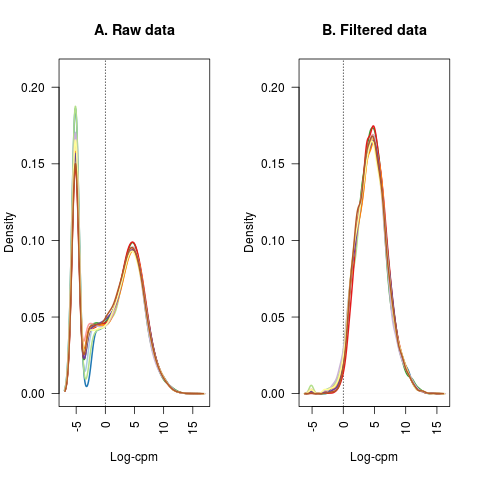

In [12]:
%%R
library(RColorBrewer)
nsamples <- ncol(x)
col <- brewer.pal(nsamples, "Paired")
par(mfrow=c(1,2))
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2,
 main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=0, lty=3)
for (i in 2:nsamples){
den <- density(lcpm[,i])
lines(den$x, den$y, col=col[i], lwd=2)
}
#legend("topright", samplenames, text.col=col, bty="n")
lcpm <- cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2,
 main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=0, lty=3)
for (i in 2:nsamples){
 den <- density(lcpm[,i])
 lines(den$x, den$y, col=col[i], lwd=2)
}
#legend("topright", samplenames, text.col=col, bty="n")

In [13]:
%%R
x <- calcNormFactors(x, method = "TMM")
x$samples$norm.factors
#print(x)
#counts.data$samples$norm.factors

 [1] 1.1425845 1.1266490 1.1149156 1.1063358 1.1795451 1.2048503 1.1355253
 [8] 1.1363614 1.0936807 1.1075902 1.0735055 1.0802964 0.6958836 0.6855480
[15] 0.8066450 1.0240694 1.0732157 1.1443269 0.7770529 0.6762607 0.6710811
[22] 1.2019876 1.1162044 1.0676021


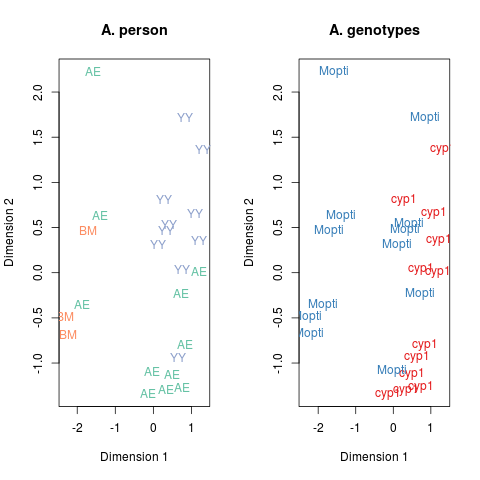

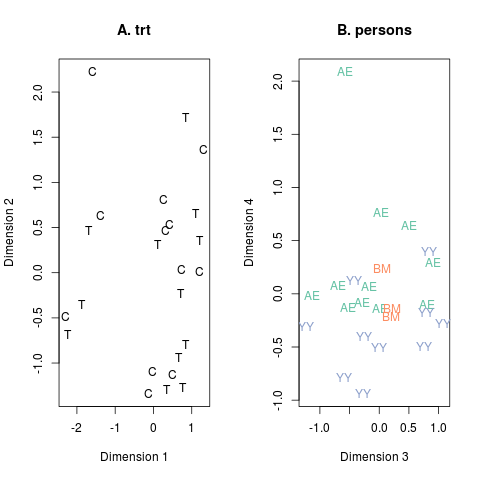

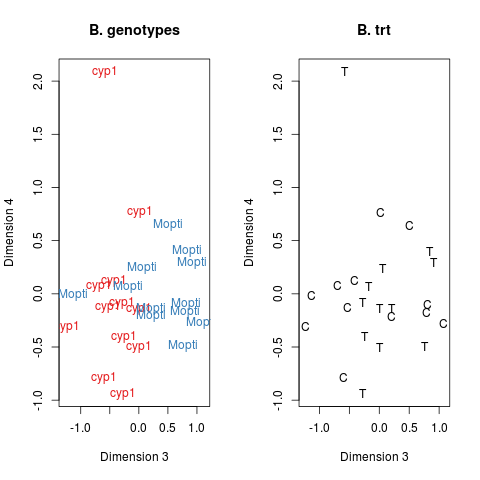

In [14]:
%%R
lcpm <- cpm(x, log=TRUE)
par(mfrow=c(1,2))

col.genotype <- genotype
levels(col.genotype) <- brewer.pal(nlevels(col.genotype), "Set1")
col.genotype <- as.character(col.genotype)

col.person <- person
levels(col.person) <- brewer.pal(nlevels(col.person), "Set2")
col.person <- as.character(col.person)

col.trt <- trt
levels(col.trt) <- brewer.pal(nlevels(col.trt), "Set3")
col.trt <- as.character(col.trt)

plotMDS(lcpm, labels=person, col=col.person)
title(main="A. person")
plotMDS(lcpm, labels=genotype, col=col.genotype)
title(main="A. genotypes")
plotMDS(lcpm, labels=trt)
title(main="A. trt")


plotMDS(lcpm, labels=person, col=col.person, dim=c(3,4))
title(main="B. persons")
plotMDS(lcpm, labels=genotype, col=col.genotype, dim=c(3,4))
title(main="B. genotypes")
plotMDS(lcpm, labels=trt, dim=c(3,4))
title(main="B. trt")

### Dim 1v2 is mostly experimentor-effect
### Dim 3v4 is mostly genotype-effect

In [15]:
%%R

group <- interaction(genotype,trt)

#Interaction effect. 2 factor ANOVA + person
design <- model.matrix(~0+group+person)  #group is a cell means model

colnames(design) <- gsub("group", "", colnames(design))
design



   cyp1.C Mopti.C cyp1.T Mopti.T personBM personYY
1       1       0      0       0        0        0
2       1       0      0       0        0        1
3       1       0      0       0        0        0
4       1       0      0       0        0        1
5       1       0      0       0        0        0
6       1       0      0       0        0        1
7       0       0      1       0        0        0
8       0       0      1       0        0        1
9       0       0      1       0        0        0
10      0       0      1       0        0        1
11      0       0      1       0        0        0
12      0       0      1       0        0        1
13      0       1      0       0        0        0
14      0       1      0       0        1        0
15      0       1      0       0        0        0
16      0       1      0       0        0        1
17      0       1      0       0        0        0
18      0       1      0       0        0        1
19      0       0      0       

In [16]:
%%R
contr.matrix <- makeContrasts(
 gt_control = cyp1.C - Mopti.C,
 gt_trt = cyp1.T - Mopti.T,
 trt_M = cyp1.T - cyp1.C,
 trt_C = Mopti.T - Mopti.C,
 gt_by_trt = (cyp1.T - Mopti.T) - (cyp1.C - Mopti.C),
    # GT = cyp1 - Mopti,
    #TRT = trtC-trtT,
 levels = colnames(design))
contr.matrix

          Contrasts
Levels     gt_control gt_trt trt_M trt_C gt_by_trt
  cyp1.C            1      0    -1     0        -1
  Mopti.C          -1      0     0    -1         1
  cyp1.T            0      1     1     0         1
  Mopti.T           0     -1     0     1        -1
  personBM          0      0     0     0         0
  personYY          0      0     0     0         0


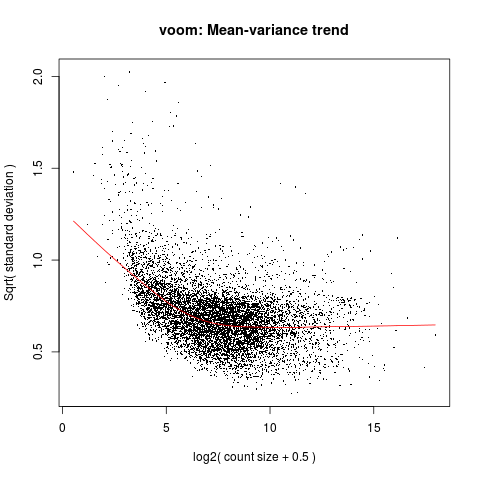

In [18]:
%%R
v <- voom(x, design, plot=TRUE)
#v

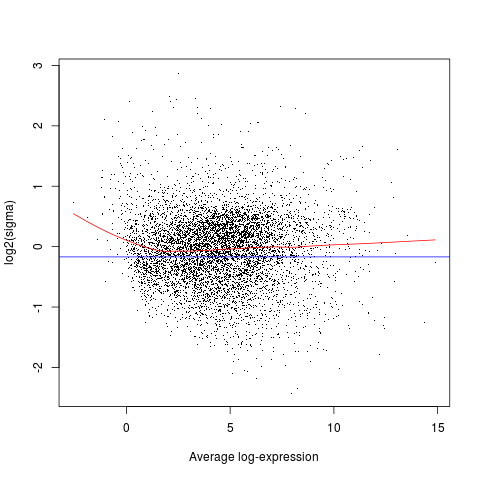

In [19]:
%%R
#apply voom precision weights to the data
vfit <- lmFit(v, design)
vfit <- contrasts.fit(vfit, contrasts=contr.matrix)
efit <- eBayes(vfit)
plotSA(efit)

In [20]:
%%R
summary(decideTests(efit))


   gt_control gt_trt trt_M trt_C gt_by_trt
-1         68     33     0     0         0
0        8359   8402  8485  8485      8485
1          58     50     0     0         0


In [21]:
%%R -o C_diff
contr.matrix <- makeContrasts(
 gt_control = cyp1.C - Mopti.C,
#  gt_trt = cyp1.T - Mopti.T,
#  trt_M = cyp1.T - cyp1.C,
#  trt_C = Mopti.T - Mopti.C,
#  gt_by_trt = (cyp1.T - Mopti.T) - (cyp1.C - Mopti.C),
    # GT = cyp1 - Mopti,
    #TRT = trtC-trtT,
 levels = colnames(design))
contr.matrix
vfit <- lmFit(v, design)

vfit <- contrasts.fit(vfit, contrasts=contr.matrix)
efit <- eBayes(vfit)
print(summary(decideTests(efit)))

C_diff <- topTable(efit, n=Inf)

write.table(C_diff, file = "C_diff.tsv",sep="\t")



   gt_control
-1         68
0        8359
1          58


In [19]:
%%R -o T_diff
contr.matrix <- makeContrasts(
#  gt_control = cyp1.C - Mopti.C,
 gt_trt = cyp1.T - Mopti.T,
#  trt_M = cyp1.T - cyp1.C,
#  trt_C = Mopti.T - Mopti.C,
#  gt_by_trt = (cyp1.T - Mopti.T) - (cyp1.C - Mopti.C),
    # GT = cyp1 - Mopti,
    #TRT = trtC-trtT,
 levels = colnames(design))
contr.matrix
vfit <- lmFit(v, design)

vfit <- contrasts.fit(vfit, contrasts=contr.matrix)
efit <- eBayes(vfit)
print(summary(decideTests(efit)))

T_diff <- topTable(efit, n=Inf)

write.table(T_diff, file = "T_diff.tsv",sep="\t")



   gt_trt
-1     33
0    8402
1      50


22 61 65
148


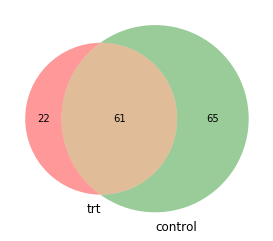

In [22]:
import pandas as pd
import matplotlib_venn as V
%matplotlib inline


#treatment DE genes
trt_diff = pd.read_csv("T_diff.csv")
trt_diff.columns = ['Acol_gene', 'logFC', 'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B']

#filter by adjusted pval
trt_sig = trt_diff.loc[trt_diff['adj.P.Val'] <= 0.05]
trt_sig.to_csv('trt.csv', index=False)
#for line in open("trt.csv"):
#    print(line.strip())
trt_genes = set(trt_sig['Acol_gene'].tolist())

#control DE genes
control_diff = pd.read_csv("C_diff.csv")
control_diff.columns = ['Acol_gene', 'logFC', 'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B']

#filter by adjusted pval
control_sig = control_diff.loc[control_diff['adj.P.Val'] <= 0.05]
control_sig.to_csv('control.csv', index=False)

control_genes = set(control_sig['Acol_gene'].tolist())

V.venn2([trt_genes,control_genes], ( "trt","control"))

trt_only = trt_genes - control_genes
control_only = control_genes - trt_genes
overlap = control_genes.intersection(trt_genes)

trt_df = trt_diff.loc[trt_diff['Acol_gene'].isin(trt_only)].drop_duplicates()
#print('trt_df', len(trt_df),trt_df)

C_df = control_diff.loc[trt_diff['Acol_gene'].isin(control_only)].drop_duplicates()
#print('C_df', len(C_df),C_df)

both_df = control_diff.loc[trt_diff['Acol_gene'].isin(overlap)].drop_duplicates()

trt = list(trt_only)
print(len(trt_df), len(both_df), len(C_df))
print(len(trt_df) + len(both_df) + len(C_df))

In [24]:
#gene conversion key
import pandas as pd
info = pd.read_csv("entrez_genes.txt", delimiter='\t')
info.columns = ['Acol_gene', 'ID', 'Agap_gene', 'Agap_ID', 'name', 'descrip', 'genbank', 'entrez', 'RefSeq']
info = info[["Acol_gene","Agap_gene","name","descrip"]]